In [36]:
% load_ext autoreload
% autoreload 2

UsageError: Line magic function `%` not found.


In [13]:
#%load_ext memory_profiler

In [41]:
from importlib import reload

from hydra import initialize, compose

from src.unit_proccessing import *


In [15]:
import pandas as pd

In [30]:
def get_df_save_path(fc: UnitDataProcessing, fname: str):
    return os.path.join(fc.config.data.raw, fc.config.surveys[0],
                        fc.config.survey_version[0], 'processed_data', fname)

def save_df(fc: UnitDataProcessing, df: pd.DataFrame, fname: str) -> None:
    save_path = get_df_save_path(fc, fname)
    pd.to_pickle(df, save_path)

def load_df(fc: UnitDataProcessing, fname: str) -> pd.DataFrame:
    load_path = get_df_save_path(fc, fname)
    return pd.read_pickle(load_path)

def drop_all_na(df: pd.DataFrame) -> pd.DataFrame:
    return df.dropna(axis=1, how='all').dropna(axis=0, how='any')


In [17]:
with initialize(config_path='../configuration', version_base='1.1'):
    config = compose(config_name='main.yaml')

In [18]:
features_class = UnitDataProcessing(config)

IMPORTING: ifad_tunesia with version EndlineFINALV106_1. 
ifad_tunesia with version EndlineFINALV106_1 loaded. 
Paradata shape: (714348, 50) Questionnaires shape: (410, 38) Microdata shape: (283454, 43) 


In [19]:
df_item = load_df(features_class, 'df_item.pkl')
df_unit = load_df(features_class, 'df_unit.pkl')
df_unit_score = load_df(features_class, 'df_unit_score.pkl')

,interview__id,responsible,s__answer_changed,s__answer_duration_lower,s__answer_duration_upper,s__answer_position,s__answer_removed,s__answer_selected_lower,s__answer_selected_upper,s__answer_time_set,...,s__spatial_outlier,s__gps,s__number_answered,s__number_unanswered,s__pause_count,s__pause_duration,s__single_question,s__time_changed,s__total_duration,s__total_elapse
0,006c75cd761b4adf9286e63d9779e679,ImenR_int_N,0.113360,0.021978,0.103865,0.270163,0.0,0.0,0.004049,0.000000,...,0.0,1,247,3.0,0.044534,693423,0.267183,0,4448.0,698383.0
1,016ba80282664bf091f51f7923bf9d34,AymenT_int_N,0.089888,0.010779,0.044788,0.343380,0.0,0.0,0.000000,0.000000,...,0.0,1,356,1.0,0.005618,119630,0.334623,0,2848.0,123386.0
2,01c88e3c31be4480963cd7cf812f5cdf,HoudaZ_int_N,0.150943,0.032537,0.052453,0.308543,0.0,0.0,0.007547,0.000000,...,0.0,1,265,1.0,0.011321,-1012,0.300896,1,2590.0,296969.0
3,01d1460d5ea34568afbd7aa5d3ef16d0,NarjesH_int_N,0.105000,0.037500,0.057500,0.245174,0.0,0.0,0.000000,0.000000,...,1.0,1,200,0.0,0.050000,1201990,0.230106,0,2798.0,1206927.0
6,0264857fdda543e1ba29a48691453e25,ImenR_int_N,0.131818,0.028182,0.105076,0.270163,0.0,0.0,0.004545,0.000000,...,0.0,1,220,0.0,0.072727,306111,0.267183,0,6663.0,312152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,fdf9aab93ef84f7f9c07abd0d4fc6bf1,RimL_int_N,0.119850,0.009704,0.042594,0.221845,0.0,0.0,0.011236,0.000000,...,0.0,1,267,0.0,0.037453,2421565,0.220999,0,2537.0,2425120.0
1174,fefe72bbd82e4c49ac5c66ee870f962b,JamelM_int,0.068182,0.017045,0.089015,0.285786,0.0,0.0,0.000000,0.000000,...,0.0,1,176,0.0,0.022727,45324,0.264013,0,2161.0,47166.0
1175,ff4350b883b54142945463ef70c84f87,AminaC_int_N,0.132701,0.024882,0.036730,0.191579,0.0,0.0,0.000000,0.014218,...,0.0,1,211,0.0,0.018957,250208,0.175474,1,1337.0,252096.0
1176,ff55f3fe7b0f405ebd7ff8a66ee1062f,AminaC_int_N,0.111111,0.025219,0.034108,0.191579,0.0,0.0,0.000000,0.031111,...,0.0,1,225,0.0,0.017778,-234190,0.175474,1,1396.0,236445.0


In [31]:
df_for_clustering = drop_all_na(df_unit_score)
keep_cols = [col for col in df_for_clustering.columns if col.startswith('s__')]
data_for_clustering = df_for_clustering[keep_cols].values
data_for_clustering

array([[0.11336032388663968, 0.02197802197802198, 0.10386543281280124,
        ..., 0, 4448.0, 698383.0],
       [0.0898876404494382, 0.010778937042981987, 0.04478776529338327,
        ..., 0, 2848.0, 123386.0],
       [0.1509433962264151, 0.03253668763102726, 0.052452830188679245,
        ..., 1, 2590.0, 296969.0],
       ...,
       [0.13270142180094788, 0.024881516587677725, 0.03672985781990521,
        ..., 1, 1337.0, 252096.0],
       [0.1111111111111111, 0.025218855218855217, 0.03410774410774411,
        ..., 1, 1396.0, 236445.0],
       [0.09417040358744394, 0.029895366218236172, 0.03795233167430477,
        ..., 0, 1579.0, 271823.0]], dtype=object)

In [52]:
import utils.alg_test_utils as alg_test_utils

reload(alg_test_utils)

<module 'utils.alg_test_utils' from 'D:\\Workspace\\Python\\proj\\mlss\\mlss\\utils\\alg_test_utils.py'>

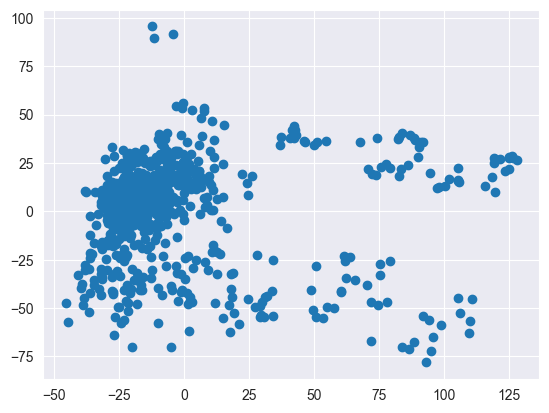

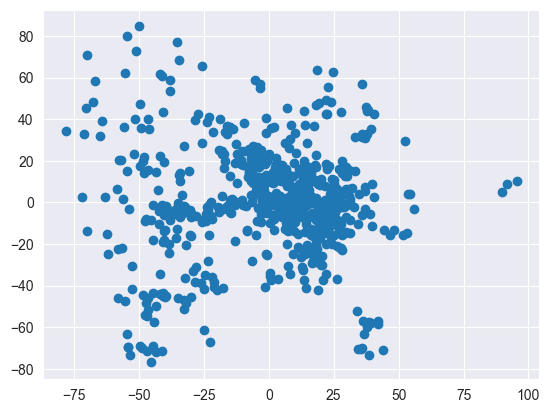

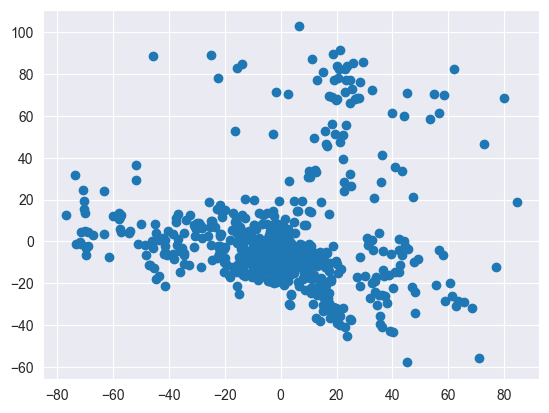

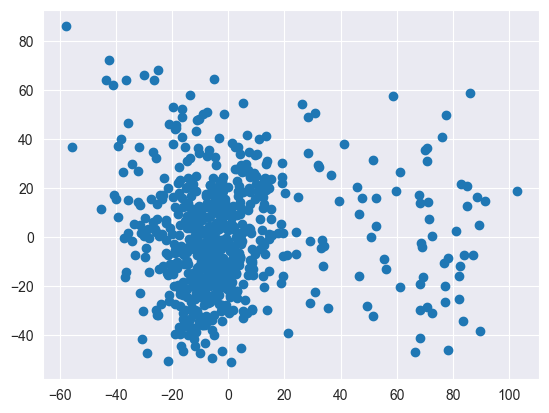

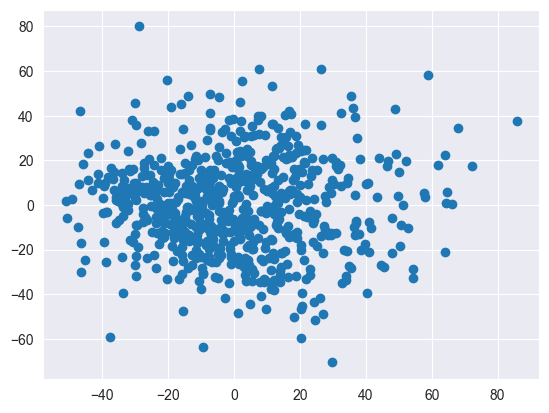

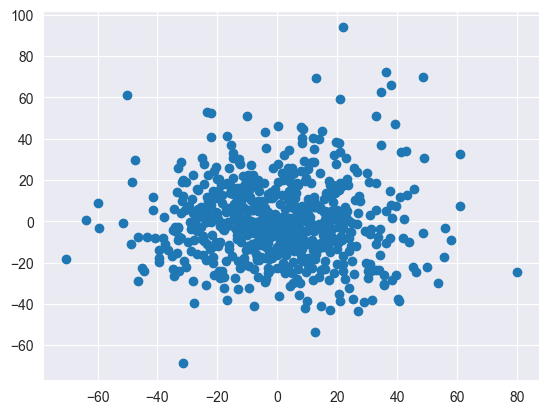

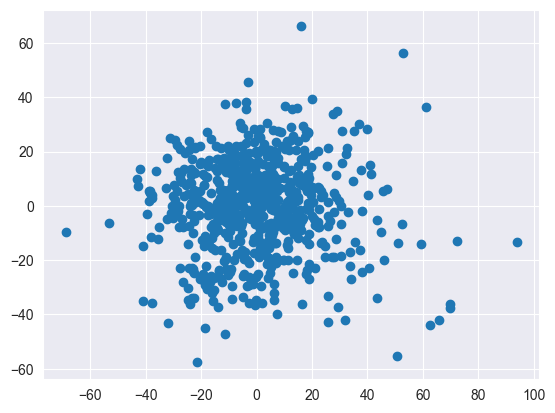

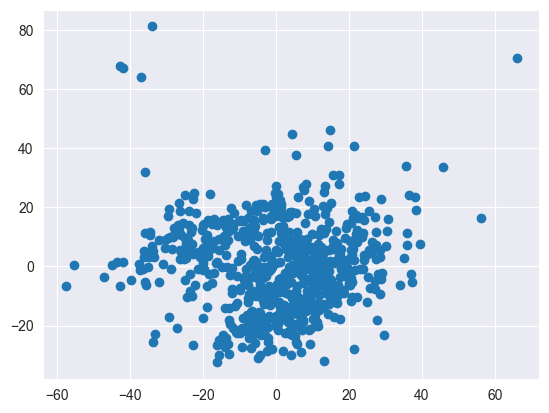

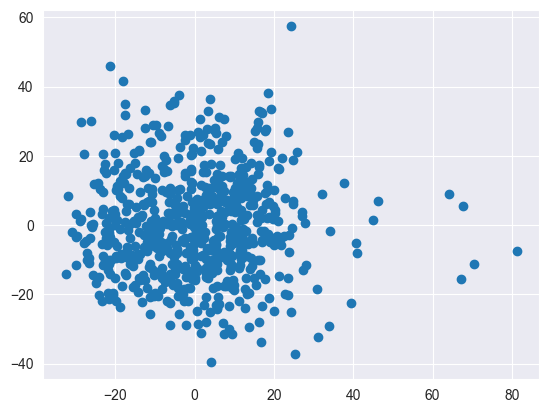

In [55]:
alg_test_utils.plot_data_pca(data_for_clustering, 20, True, 0, 9)

In [9]:
np.std([1,2,3, 3,3,3,3,])

32.22867512014727